In [1]:
import numpy as np
import tensorflow as tf
import struct
import matplotlib.pyplot as plt

In [2]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [3]:
#loading the dataset 
data = read_idx('/Users/Ronja/Desktop/ANNh/hw2/MNISt/train-images.idx3-ubyte')
data = (data/255) * 2 - 1
print(data.shape)

(60000, 28, 28)


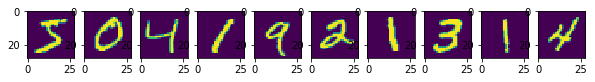

In [4]:
# displaying the first 10 training examples
fig, ax = plt.subplots(1,10,figsize=(10,10))
for i in range(10): ax[i].imshow(data[i])

## Building the model

In [5]:
#helper functions
def feed_forward_layer(x, hidden_n, activation_fn, normalize):
    initializer = tf.random_normal_initializer(stddev=0.02)
    weights = tf.get_variable("weights", [x.shape[1], hidden_n], tf.float32, initializer)
    biases = tf.get_variable("biases", [hidden_n], tf.float32, tf.zeros_initializer())
   
    drive = tf.matmul(x, weights) + biases
    if normalize:
        drive = batch_norm(drive, [0])
   
    if activation_fn == 'linear':
        return drive
    else:
        return activation_fn(drive)


def conv_layer(x, kernels_n, kernel_size, stride_size, activation_fn, normalize):
    initializer = tf.random_normal_initializer(stddev=0.02)
    kernels = tf.get_variable("kernels", [kernel_size, kernel_size, x.shape[-1], kernels_n], tf.float32, initializer)
    biases = tf.get_variable("biases", [kernels_n], tf.float32, tf.zeros_initializer())

    drive = tf.nn.conv2d(x, kernels, strides = [1, stride_size, stride_size, 1], padding = "SAME") + biases
    if normalize:
        drive = batch_norm(drive, [0,1,2])
    
    return activation_fn(drive)


def back_conv_layer(x, target_shape, kernel_size, stride_size, activation_fn, normalize):
    initializer = tf.random_normal_initializer(stddev=0.02)
    kernels = tf.get_variable("kernels", [kernel_size, kernel_size, target_shape[-1], x.shape[-1]], tf.float32, initializer)
    biases = tf.get_variable("biases", [target_shape[-1]], tf.float32, tf.zeros_initializer())

    drive = tf.nn.conv2d_transpose(x, kernels, target_shape, strides = [1, stride_size, stride_size, 1], padding = "SAME") + biases
    if normalize:
        drive = batch_norm(drive, [0,1,2])
    
    return activation_fn(drive)


def flatten(x):
    size = int(np.prod(x.shape[1:]))
    return tf.reshape(x, [-1, size])


def batch_norm(x, axes):
    mean, var = tf.nn.moments(x, axes = axes)
    offset_initializer = tf.constant_initializer(0.0)
    offset = tf.get_variable("offset", [x.shape[-1]], tf.float32, offset_initializer)
    scale_initializer = tf.constant_initializer(1.0)
    scale = tf.get_variable("scale", [x.shape[-1]], tf.float32, scale_initializer)
    return tf.nn.batch_normalization(x, mean, var, offset, scale, 1e-6)

All convolutional and transposed-convolutional layers use ker- nel size 5 and stride size 2!

In [6]:
kernel_size = 5
stride_size = 2

### Input to Generator
In each training step the generator will get 32 random vectors of dimension 50. For that we need a placeholder. The random vectors will be generated later in the session.


In [7]:
vectors = tf.placeholder(tf.float32, shape=(32,50))
print(vectors)

Tensor("Placeholder:0", shape=(32, 50), dtype=float32)


### Generator Layer 1
The first layer is a fully connected feed forward layer with 1024 hidden nodes. Use ReLU activation function and batch norm. The 1024 nodes are then reshaped to 64 feature maps of size 4x4.

In [8]:
with tf.variable_scope("generator_layer1", reuse=tf.AUTO_REUSE):
    x = vectors
    hidden_n = 1024
    activation_fn = tf.nn.relu
    normalize = True
    #applying feed_forward layer
    feed_forward_output = feed_forward_layer(x, hidden_n, activation_fn, normalize)
    #reshape to 64 feature maps of size 4x4
    layer_1 = tf.reshape(tensor = feed_forward_output, shape = (32,4,4,64))
    print(layer_1)

Tensor("generator_layer1/Reshape:0", shape=(32, 4, 4, 64), dtype=float32)


### Generator Layer 2
This layer is a transposed convolutional layer. Layer 2 upsamples the previous 64 feature maps to 32 feature maps of size 7x7. Use ReLU activation function and batch norm.

In [9]:
with tf.variable_scope("generator_layer2", reuse=tf.AUTO_REUSE):
    x = layer_1
    target_shape = [32, 7, 7, 32]
    activation_fn = tf.nn.relu
    normalize = True
    layer_2 = back_conv_layer(x, target_shape, kernel_size, stride_size, activation_fn, normalize)
print(layer_2)

Tensor("generator_layer2/Relu:0", shape=(32, 7, 7, 32), dtype=float32)


### Generator Layer 3
This layer is a transposed convolutional layer. Layer 3 upsamples to 16 feature maps of size 14x14. Use ReLU activation function and batch norm.


In [10]:
with tf.variable_scope("generator_layer3", reuse=tf.AUTO_REUSE):
    x = layer_2
    target_shape = (32,14,14,16)
    activation_fn = tf.nn.relu
    normalize = True
    layer_3 = back_conv_layer(x, target_shape, kernel_size, stride_size, activation_fn, normalize)
print(layer_3)

Tensor("generator_layer3/Relu:0", shape=(32, 14, 14, 16), dtype=float32)


### Generator Layer 4
This layer is the last transposed convolutional layer and will generate the images. It will thus sample up to only one map of size 28x28. Do not use batch norm and use the TanH activation function.

In [11]:
with tf.variable_scope("generator_layer4", reuse=tf.AUTO_REUSE):
    x = layer_3
    target_shape = (32,28,28,1)
    activation_fn = tf.nn.tanh
    normalize = False
    generator_layer_4 = back_conv_layer(x, target_shape, kernel_size, stride_size, activation_fn, normalize)
    print(generator_layer_4)
    #layer_4 = tf.reshape(layer_4, (32,28,28))
    #print(layer_4)

Tensor("generator_layer4/Tanh:0", shape=(32, 28, 28, 1), dtype=float32)


## Discriminator

### Input to Discriminator
The discriminator will get the 32 previously generated images together with 32 original images as an input. Use as usual the tf.data API to build a dataset and an iterator that gives you batches of 32 of the original images. Use tf.concat to build one batch of 64 out of the original and the generated images.

In [12]:
# create the tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices(data)

# define the batch size
batchsize = 32

# split the dataset into batches
dataset = dataset.batch(batchsize)

# shuffel the data (in each epoch)
dataset = dataset.shuffle(buffer_size=4, reshuffle_each_iteration = True)

# create an iterator
iterator = tf.data.Iterator.from_structure(dataset.output_types, dataset.output_shapes)

# name operation that gives next batch
next_batch = iterator.get_next()

# initializer operations for training and validation dataset
initialize_iterator = iterator.make_initializer(dataset)


In [13]:
#making next batch and output of generator compatible
next_batch = tf.cast(next_batch, tf.float32)
next_batch = tf.reshape(next_batch,[-1, 28, 28, 1])
generator_layer_4 = tf.cast(generator_layer_4, tf.float32)

#combining next batch and ouput of generator
mixed_batch = tf.concat([generator_layer_4, next_batch], 0)
print(mixed_batch)
#labels_original = tf.cast(tf.ones(32), tf.int32)
#labels_generated = tf.cast(tf.zeros(32), tf.int32)
#labels = tf.concat([labels_original, labels_generated], 0)
#print(mixed_batch)

Tensor("concat:0", shape=(?, 28, 28, 1), dtype=float32)


### Discriminator Layer 1, 2 & 3
All three layers are normal convolutional layers with respectively 8, 16 and 32 feature maps. All use ”same”-padding, leaky ReLU activation function and batch normalization.

In [14]:
with tf.variable_scope("discriminator1-3", reuse=tf.AUTO_REUSE):
    activation_fn = tf.nn.leaky_relu
    normalize = True
    
    print((mixed_batch))
    with tf.variable_scope("discriminator1", reuse=tf.AUTO_REUSE):
        x = tf.reshape(mixed_batch, (64,1,28,28))
        kernels_n = 8
        disc_layer1 = conv_layer(x, kernels_n, kernel_size, stride_size, activation_fn, normalize)
    
    with tf.variable_scope("discriminator2", reuse=tf.AUTO_REUSE):
        x = disc_layer1
        kernels_n = 16
        disc_layer2 = conv_layer(x, kernels_n, kernel_size, stride_size, activation_fn, normalize)
    
    with tf.variable_scope("discriminator3", reuse=tf.AUTO_REUSE):
        x = disc_layer2
        kernels_n = 32
        disc_layer3 = conv_layer(x, kernels_n, kernel_size, stride_size, activation_fn, normalize)
    
    #print(disc_layer1)
    #print(disc_layer2)
    #print(disc_layer3)

Tensor("concat:0", shape=(?, 28, 28, 1), dtype=float32)


### Discriminator Layer 4
The last layer is a fully connected feed forward layer. For that we first need to flatten the feature maps of the last layer. The layer only has one output node as the discriminator only has to distinct between original images (label: 1) and generated images (label: 0). Do not use any activation function but do use batch norm.

In [15]:
 with tf.variable_scope("discriminator4", reuse=tf.AUTO_REUSE):
        x = tf.reshape(disc_layer3,(64,128))
        hidden_n = 1
        normalize = True
        activation_fn = 'linear'
        disc_layer4 = feed_forward_layer(x, hidden_n, activation_fn, normalize)
print(disc_layer4)

Tensor("discriminator4/batchnorm/add_1:0", shape=(64, 1), dtype=float32)


## Training
The training is a bit trickier as usual as we have to train the generator and the discriminator separately. Both will be optimized with Adam (learning rate = 0.0004, beta1 = 0.5).


### Training the Generator
You need 32 ones as labels (remember the generator wants to fool the discrim- inator). 

Calculate the loss with tf.nn.sigmoid cross entropy with logits. Pay attention that you feed the correct half of the logits (the logits that corre- spond to the generated images) to the loss function. 

Take the mean.

We only want to train the generator to minimize this loss. Use the following code snippet to get all variables that are part of the generator.

trainable variables = tf.trainable variables()

generator variables = [var for var in trainable variables if "generator" in var.name]

This presupposes you use sensible variable scopes for your layers.

Now you can initialize an Adam optimizer and instruct it to minimize the loss. 

The minimize functions has a parameter var list that you can pass the above generated list.

In [16]:
with tf.variable_scope("training_generator", reuse=tf.AUTO_REUSE) as scope:    
    logits = disc_layer4[0:32]
    #logits = tf.reshape(logits, (32,))
    print(logits)
    labels = tf.ones((32,1))
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
    print(cross_entropy)
    generator_loss = tf.reduce_mean(cross_entropy)
    print(generator_loss)

    trainable_variables = tf.trainable_variables()
    generator_variables = [var for var in trainable_variables if "generator" in var.name]

    #defining the learning rate
    learning_rate = 4e-4

    #defining the optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1 = 0.5)

    #define training step
    training_step_generator = optimizer.minimize(generator_loss, var_list = generator_variables)


Tensor("training_generator/strided_slice:0", shape=(32, 1), dtype=float32)
Tensor("training_generator/logistic_loss:0", shape=(32, 1), dtype=float32)
Tensor("training_generator/Mean:0", shape=(), dtype=float32)


### Training the Discriminator
Now you need 64 labels (32 ones and 32 zeros). Again make sure that the order matches how you concatenated original and generated images as the input for the discriminator ([original, generated] or [generated, original]). The rest is exactly as above.

In [17]:
with tf.variable_scope("training_discriminator", reuse=tf.AUTO_REUSE) as scope: 
    labels_original = tf.cast(tf.ones((32,1)), tf.float32)
    labels_generated = tf.cast(tf.zeros((32,1)), tf.float32)
    labels = tf.concat([labels_original, labels_generated], 0)
    print(labels)
    logits = disc_layer4
    print(logits)
    
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
    print(cross_entropy)
    discriminator_loss = tf.reduce_mean(cross_entropy)
    print(discriminator_loss)

    trainable_variables = tf.trainable_variables()
    generator_variables = [var for var in trainable_variables if "discriminator" in var.name]

    #defining the learning rate
    learning_rate = 4e-4

    #defining the optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1 = 0.5)

    #define training step
    training_step_discriminator = optimizer.minimize(discriminator_loss, var_list = generator_variables)



Tensor("training_discriminator/concat:0", shape=(64, 1), dtype=float32)
Tensor("discriminator4/batchnorm/add_1:0", shape=(64, 1), dtype=float32)
Tensor("training_discriminator/logistic_loss:0", shape=(64, 1), dtype=float32)
Tensor("training_discriminator/Mean:0", shape=(), dtype=float32)


### Monitoring
Use TensorBoard to visualize the losses and the generated images.

discriminator_loss_summary = tf.summary.scalar("discriminator-loss", discriminator loss)

loss_summaries = tf.summary.merge([generator loss summary, discriminator loss summary]) 

generated_images_summary = tf.summary.image("generated-images", generated images, max_outputs = 32)

Read out the loss summaries in each training step. The generated images as explained above only each 100th step.

In [18]:
discriminator_loss_summary = tf.summary.scalar("discriminator-loss", discriminator_loss)
generator_loss_summary = tf.summary.scalar("generator-loss", generator_loss)
loss_summaries = tf.summary.merge([generator_loss_summary, discriminator_loss_summary])
generated_images_summary = tf.summary.image("generated-images", generator_layer_4, max_outputs = 32)
#where to write the summaries
train_writer = tf.summary.FileWriter('./summaries/train/')

## Training and Generating Images

Train the model for 2 epochs.
In the very beginning of your session once sample 32 random vectors of dimen- sion 50 from a uniform distribution (between -1 and 1). We will use these to visualize our progress in the generation.
In each training step sample 32 new random vectors of dimension 50 from the same distribution. These will be fed to the generator for training. This is why they have to be different in each training step.
Run the training step (both training steps) while feeding the previously gen- erated vector to the placeholder.
After each 100th training step feed in the vector sampled at the beginning and read out the summaries for the generated images (do not train).


In [19]:
#uniform distribution from which we sample in each training step
distribution = tf.distributions.Uniform(-1.0,1.0)
print(distribution)

#defining the epochs
epochs = 2

#starting Tensorflow session
with tf.Session() as sess:
    #inizializing variables
    sess.run(tf.global_variables_initializer())
    #making global step counter
    global_step = 0
    
    #defining the epoch loop (runs through training and validation epoch number of times)
    for _ in range(epochs):
        #initializing iterator with training data for this epoch
        sess.run(initialize_iterator)
        
        #going through all batches once
        while True:
            try:
                #sampling from uniform distribution
                #random_vectors = distribution.sample((32,50))
                random_vectors = np.random.uniform(size=(32,50))
                if((global_step % 100) == 0):
                    summary_images = sess.run([generated_images_summary], feed_dict={vectors : random_vectors})
                    train_writer.add_summary(summary_images[0], global_step)
                else:
                    #running training steps, feeding in random vectors and reading out summary
                    summaries, _, _ = sess.run([loss_summaries, training_step_generator, training_step_discriminator], feed_dict={vectors : random_vectors})
                    #saving the summary
                    train_writer.add_summary(summaries, global_step)

                global_step = global_step + 1
            except tf.errors.OutOfRangeError:
                break

tf.distributions.Uniform("Uniform/", batch_shape=(), event_shape=(), dtype=float32)
